# Random Forest Classifier on Spark
**Example 4.0a, Random Forest classifier:** This trains a particle classifier using Random Forest distributed using PySpark ML APIs.

The High-Level Features classifier is built with labeled data
 - input: 14 features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
![Physics use case for the particle classifier](../Docs/Physics_use_case.png)

To run this notebook we used the following configuration:

The notebook has been tested using the following configuration:
* *Software stack*: Spark 3.5.1
* *Platform*: CentOS 7, Python 3.11
* *Spark cluster*: Analytix

In [1]:
# No need to run this when using CERN SWAN service
# Just add the configuration parameters for Spark on the "star" button integration

# ! pip install pyspark 
# or use your favorite way to set Spark Home, here we use findspark
# import findspark
# findspark.init('/home/luca/Spark/spark-3.5.1-bin-hadoop3') #set path to SPARK_HOME

# Create Spark session and configure according to your environment
from pyspark.sql import SparkSession

spark = ( SparkSession.builder
          .appName("Training-RandomForestClassifier")
          .master("yarn")
          .config("spark.driver.memory","4g")
          .config("spark.executor.memory","32g")
          .config("spark.executor.cores","8")
          .config("spark.sql.execution.arrow.pyspark.enabled", "true")
          .config("spark.dynamicAllocation.enabled", "true")
          .config("spark.ui.showConsoleProgress", "false")
          .getOrCreate()
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting Spark log level to "ERROR".


In [2]:
spark

## Load train and test dataframes

In [3]:
# For CERN users, data is already available in the Analytix cluster

# Open data: download the test and training data sets as described at
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
# DATASET_NAME="trainUndersampled.parquet"
# wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME
# 

# PATH = "./" # use the path where you downloaded the data
# For CERN users, data is already available on the Analytix Hadoop cluster
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = ( spark.read.format('parquet')
              .load(PATH + 'trainUndersampled.parquet')
              .select(['hfeatures', 'label', 'encoded_label'])
          )
        
testDF = ( spark.read.format('parquet')
             .load(PATH + 'testUndersampled.parquet')
             .select(['hfeatures', 'label', 'encoded_label'])
         )

In [4]:
# Optionally count the number of events in the training and test datasets
print('There are', trainDF.count(), 'training events')
print('There are', testDF.count(), 'test events')

There are 3426083 training events
There are 856090 test events


In [5]:
# There are 14 High Level Features for this classifier, 
# packed into a vector in the "features" column
# The label can take 3 possible values. Details at:
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data

trainDF.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [6]:
testDF.show(3)

+--------------------+-----+-------------+
|           hfeatures|label|encoded_label|
+--------------------+-----+-------------+
|[74.9491729736328...|    0|(3,[0],[1.0])|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|
|[47.6835403442382...|    0|(3,[0],[1.0])|
+--------------------+-----+-------------+
only showing top 3 rows



## Train the classifier using Random Forest

In [7]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=100, maxDepth=10,
                            featuresCol='hfeatures',
                            labelCol="label",
                            predictionCol='prediction')

In [8]:
%time rf_model = rf.fit(trainDF)

CPU times: user 39.8 ms, sys: 16.5 ms, total: 56.3 ms
Wall time: 2min 22s


## Save the model

In [9]:
# save the model to the local filesystem
rf_model.save(path='file:/tmp/models/RandomForest/rf_model')

In [10]:
# reload with:
# from pyspark.ml.classification import RandomForestClassificationModel
# rf_model = RandomForestClassificationModel.load('file:/tmp/models/RandomForest/rf_model')

## Prediction

In [10]:
pred = rf_model.transform(testDF)

In [11]:
pred.show(5)

+--------------------+-----+-------------+--------------------+--------------------+----------+
|           hfeatures|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[74.9491729736328...|    0|(3,[0],[1.0])|[93.7728539543836...|[0.93772853954383...|       0.0|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|[81.1985007737511...|[0.81198500773751...|       0.0|
|[47.6835403442382...|    0|(3,[0],[1.0])|[92.5992438760003...|[0.92599243876000...|       0.0|
|[80.9036312103271...|    0|(3,[0],[1.0])|[75.5499389767498...|[0.75549938976749...|       0.0|
|[95.2762756347656...|    0|(3,[0],[1.0])|[94.9296421593247...|[0.94929642159324...|       0.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute the AUC

In [12]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [13]:
%time pred_pd = pred.select(['encoded_label', 'probability']).toPandas()

CPU times: user 822 ms, sys: 305 ms, total: 1.13 s
Wall time: 20.5 s


In [14]:
pred_pd.head()

,encoded_label,probability
0,"[1.0, 0.0, 0.0]","[0.9377285395438365, 0.010669086510951196, 0.0..."
1,"[1.0, 0.0, 0.0]","[0.8119850077375115, 0.00981041049523864, 0.17..."
2,"[1.0, 0.0, 0.0]","[0.9259924387600034, 0.025907072709736523, 0.0..."
3,"[1.0, 0.0, 0.0]","[0.7554993897674989, 0.05289757738800433, 0.19..."
4,"[1.0, 0.0, 0.0]","[0.9492964215932475, 0.029873954399491316, 0.0..."


In [15]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['probability'].tolist())

In [16]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


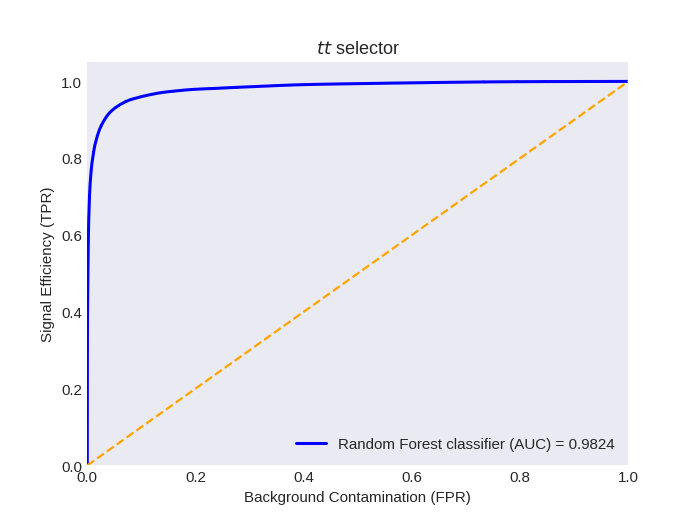

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


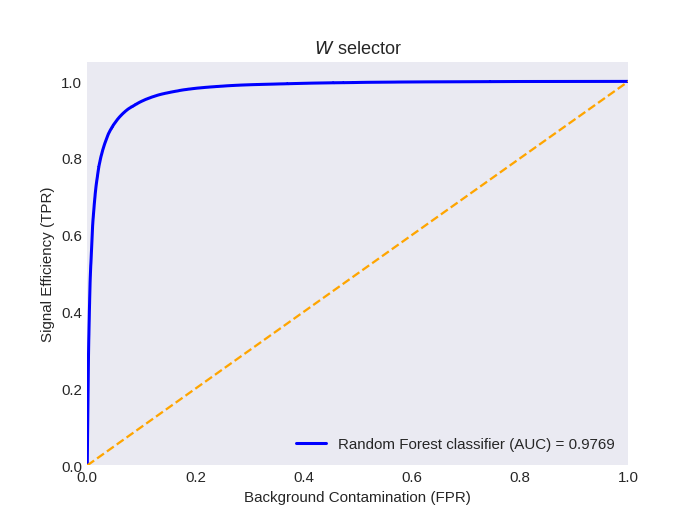

In [18]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Confusion Matrix

In [19]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9078


<IPython.core.display.Javascript object>


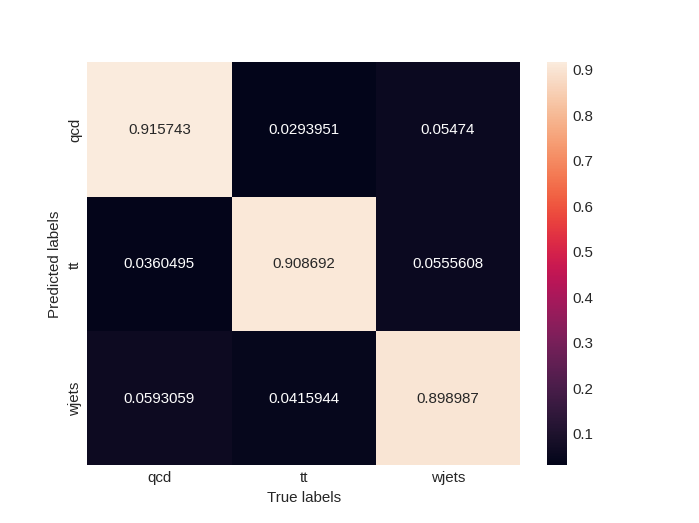

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [21]:
spark.stop()